In [32]:
import overpass
from pprint import pprint
import requests
import time
from openrouteservice import client

try:
    import matplotlib.pyplot as plt
    plot = True
except ImportError:
    plot = False

ovp_api = overpass.API(timeout=600)
key_gen = api_key_generator()
        
openroute_api_key  = '5b3ce3597851110001cf62480279a95227aa4e5f9ccf7cfa946e69f3'
openroute_api_key2 = '5b3ce3597851110001cf62481791fec0246a4ac9badab061925938ea' 
opr_client = client.Client(key=openroute_api_key)    

## Overpass API

In [16]:
search_range = [10000, 50000, 100000, 200000]
distance_range = [5000, 10000]

In [17]:
queries = [
    # supermarkets (around location)
    'node["shop"="supermarket"](around:2000.0, 51.782065, 19.459279);',
    
    # cafes or fast_foods with polish website (around location)
    'node["amenity"~"cafe|fast_food"]["website"~".pl/$"](around:2000.0, 51.782065, 19.459279);',
    
    # banks far away from police (around location)
    'nwr["amenity"="police"](around:2000, 51.782065, 19.459279)->.polices;\
    nwr["amenity"="bank"](around:1000, 51.782065, 19.459279)->.banks;\
    nwr.banks(around.polices:1000)->.banksNearPolices;\
    (.banks; - .banksNearPolices;);out;',
    
    # hotels near lakes (around location)
    'nwr["tourism"="hotel"](around:100000, 51.782065, 19.459279)->.hotels;\
    nwr["water"="lake"]["name"~"^Jezioro"](around:101000, 51.782065, 19.459279)->.lakes;\
    nwr.hotels(around.lakes:1000);out;'
]

In [22]:
def single_benchmark(q):
    s = time.time()
    response = ovp_api.get(q)
    return time.time() - s, len(response['features'])

def benchmark_queries(queries, ranges, sleep_time=4):
    sleep = sleep_time
    attempts = 0
    for q, r in zip(queries, ranges):
        td = None
        while td is None and attempts < 4:
            try:
                td, items = single_benchmark(q)
                sleep = sleep_time
                attempts = 0
            except:
                print('error occured')
                sleep *= 2
                time.sleep(sleep)
                attempts += 1    
        
        if td is None:
            print('Error, to many attempts')
            return
            
        print('range: ', r, ' results: ', items, ' time: ', round(td,2), ' seconds')
        time.sleep(sleep)

### simple search

In [23]:
# supermarkets (around location)
queries = ['node["shop"="supermarket"](around:{}, 51.782065, 19.459279);'.format(r) for r in search_range]
benchmark_queries(queries, search_range)

error occured
range:  10000  results:  70  time:  0.6  seconds
range:  50000  results:  181  time:  1.83  seconds
range:  100000  results:  424  time:  2.5  seconds
range:  200000  results:  2486  time:  14.42  seconds


In [24]:
# cafes or fast_foods with polish website (around location)
queries = ['node["amenity"~"cafe|fast_food"]["website"~".pl/$"](around:{}, 51.782065, 19.459279);'.format(r) for r in search_range]
benchmark_queries(queries, search_range)

range:  10000  results:  16  time:  10.31  seconds
range:  50000  results:  20  time:  7.06  seconds
error occured
range:  100000  results:  29  time:  9.71  seconds
range:  200000  results:  324  time:  15.18  seconds


### advanced search

In [27]:
# cafes or fast_foods with polish website (around location)
queries = ['nwr["amenity"="police"](around:{}, 51.782065, 19.459279)->.polices;\
    nwr["amenity"="bank"](around:{}, 51.782065, 19.459279)->.banks;\
    nwr.banks(around.polices:{})->.banksNearPolices;\
    (.banks; - .banksNearPolices;);out;'.format(r, r, d) for r in search_range for d in distance_range]
ranges = [(r,d) for r in search_range for d in distance_range]
benchmark_queries(queries, ranges, sleep_time=20)

range:  (10000, 5000)  results:  0  time:  5.38  seconds
range:  (10000, 10000)  results:  0  time:  3.11  seconds
range:  (50000, 5000)  results:  42  time:  3.86  seconds
range:  (50000, 10000)  results:  14  time:  3.64  seconds
range:  (100000, 5000)  results:  170  time:  6.71  seconds
range:  (100000, 10000)  results:  86  time:  9.68  seconds
range:  (200000, 5000)  results:  604  time:  57.24  seconds
range:  (200000, 10000)  results:  262  time:  46.64  seconds


In [74]:
# hotels near lakes (around location)    
r = 90000
# for r >= 100 000 there is some overpass error - corrupted polygon 
d = 10000
query = 'nwr["tourism"="hotel"](around:{}, 51.782065, 19.459279)->.hotels;\
    nwr["water"="lake"]["name"~"^Jezioro"](around:{}, 51.782065, 19.459279)->.lakes;\
    nwr.hotels(around.lakes:{});out;'.format(r, r, d)
single_benchmark(query)

(17.870610237121582, 28)

## OpenRouteService

In [69]:
def openroute_benchmark(params):
    s = time.time()
    response = opr_client.isochrones(**params)
    dt = time.time() - s
    points = response['features'][0]['geometry']['coordinates'][0]

    print('time ', round(dt,2))

    if plot:
        plot_points(points)  

In [66]:
def plot_points(points):
    x = []
    y = []
    for p in points:
        x.append(p[0])
        y.append(p[1])
    plt.plot(x,y)    

time  0.28


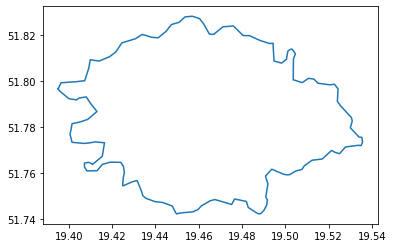

In [70]:
params = {
    'locations': [(19.459279, 51.782065)],
    'profile': 'driving-car',
    'range_type': 'time',
    'range': [10*60],
    'smoothing': 1.
}

openroute_benchmark(params)  

time  1.65


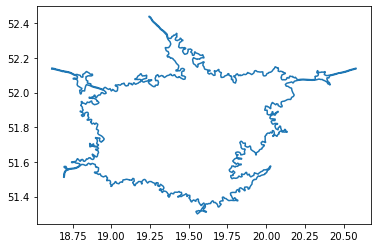

In [73]:
params = {
    'locations': [(19.459279, 51.782065)],
    'profile': 'driving-car',
    'range_type': 'time',
    'range': [60*60],
    'smoothing': 1.
}

openroute_benchmark(params)  

time  0.1


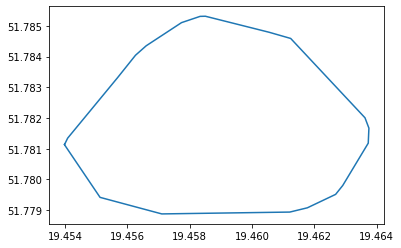

In [71]:
params = {
    'locations': [(19.459279, 51.782065)],
    'profile': 'foot-walking',
    'range_type': 'time',
    'range': [5*60],
    'smoothing': 0.75
}
openroute_benchmark(params)

In [54]:
def makePolyStr(opr_coords):
    coord_str = '"'
    for coord in opr_coords:
        coord_str += str(coord[1]) + ' ' + str(coord[0]) + ' '
    coord_str = coord_str.rstrip(' ')
    coord_str += '"'
    return '(poly:{})'.format(coord_str)

def makeAroundLineStr(around_dist_m, opr_coords):
    coord_str = ''
    for coord in opr_coords:
        coord_str += ',' + str(coord[1]) + ',' + str(coord[0])
    return '(around:{}{})'.format(around_dist_m, coord_str)

print(makePolyStr(resp2['features'][0]['geometry']['coordinates'][0]))
print(makeAroundLineStr(100, resp2['features'][0]['geometry']['coordinates'][0]))

(poly:"51.781136 19.453986 51.781119 19.453991 51.779415 19.455125 51.778876 19.457105 51.778936 19.461211 51.779075 19.461775 51.779512 19.462681 51.779802 19.46291 51.78118 19.463728 51.781669 19.463749 51.782006 19.463623 51.784589 19.46124 51.784791 19.460546 51.785312 19.458504 51.785308 19.458335 51.785104 19.457738 51.78435 19.456605 51.784042 19.456262 51.783315 19.455689 51.781343 19.454086 51.781136 19.453986")
(around:100,51.781136,19.453986,51.781119,19.453991,51.779415,19.455125,51.778876,19.457105,51.778936,19.461211,51.779075,19.461775,51.779512,19.462681,51.779802,19.46291,51.78118,19.463728,51.781669,19.463749,51.782006,19.463623,51.784589,19.46124,51.784791,19.460546,51.785312,19.458504,51.785308,19.458335,51.785104,19.457738,51.78435,19.456605,51.784042,19.456262,51.783315,19.455689,51.781343,19.454086,51.781136,19.453986)


In [58]:
opr_coords = resp2['features'][0]['geometry']['coordinates'][0]
dist_m = 100
ovp_query_1 = '(nwr["shop"="convenience"]{};\
nwr["shop"="convenience"]{};)->.shops;\
nwr["tourism"="apartment"]{}->.apartments;\
nwr.apartments(around.shops:{});\
out;'.format(makePolyStr(opr_coords), makeAroundLineStr(dist_m, opr_coords), makePolyStr(opr_coords), dist_m)
print(ovp_query_1)
ovp_resp_1 = ovp_api.get(ovp_query_1)
pprint(ovp_resp_1)

(nwr["shop"="convenience"](poly:"51.781136 19.453986 51.781119 19.453991 51.779415 19.455125 51.778876 19.457105 51.778936 19.461211 51.779075 19.461775 51.779512 19.462681 51.779802 19.46291 51.78118 19.463728 51.781669 19.463749 51.782006 19.463623 51.784589 19.46124 51.784791 19.460546 51.785312 19.458504 51.785308 19.458335 51.785104 19.457738 51.78435 19.456605 51.784042 19.456262 51.783315 19.455689 51.781343 19.454086 51.781136 19.453986");nwr["shop"="convenience"](around:100,51.781136,19.453986,51.781119,19.453991,51.779415,19.455125,51.778876,19.457105,51.778936,19.461211,51.779075,19.461775,51.779512,19.462681,51.779802,19.46291,51.78118,19.463728,51.781669,19.463749,51.782006,19.463623,51.784589,19.46124,51.784791,19.460546,51.785312,19.458504,51.785308,19.458335,51.785104,19.457738,51.78435,19.456605,51.784042,19.456262,51.783315,19.455689,51.781343,19.454086,51.781136,19.453986);)->.shops;nwr["tourism"="apartment"](poly:"51.781136 19.453986 51.781119 19.453991 51.779415 19

## TagInfo API

In [75]:
payload = {
    'key': 'amenity',
    'page': 1,
    'rp': 30,
    'sortname': 'count_all',
    'sortorder': 'desc'    
}

r = requests.get('https://taginfo.openstreetmap.org/api/4/key/values', payload)
vals = [e['value'] for e in r.json()['data']]
pprint(vals)

['parking',
 'bench',
 'place_of_worship',
 'restaurant',
 'school',
 'parking_space',
 'fuel',
 'waste_basket',
 'cafe',
 'fast_food',
 'bank',
 'bicycle_parking',
 'shelter',
 'toilets',
 'pharmacy',
 'post_box',
 'recycling',
 'kindergarten',
 'drinking_water',
 'hospital',
 'bar',
 'atm',
 'grave_yard',
 'post_office',
 'pub',
 'vending_machine',
 'hunting_stand',
 'clinic',
 'police',
 'doctors']
